In [ ]:
!pip3 install jupyter numpy scikit-learn matplotlib keras


<h1> Step 1: Load and prepare data </h1>

In [2]:
from keras.datasets import mnist
import numpy as np

# Load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess and flatten the images
x_train = x_train.reshape((x_train.shape[0], -1)).astype('float32') / 255
x_test = x_test.reshape((x_test.shape[0], -1)).astype('float32') / 255

# Convert to numpy arrays for scikit-learn compatibility
y_train = np.array(y_train)
y_test = np.array(y_test)


11490434/11490434 [==============================] - 1s 0us/step


<h1> Step 2: Implementing Uncertantiy samping with visulization </h1> <br>

The steps that the code performs can be broken down into the following steps <br>

<strong>1. Model prediction: </strong> The model makes predictions on the unlabeled data, estimating probabilities for each potential label <br> <strong> 2. Measure uncertainty: </strong> We quantify how uncertain the model is about each prediction <br> <strong> 3. Select data points </strong> The model selects the data points it is most uncertain about. These are the instances where its preictions are closests to being a guss among all others <br> <strong> Label and updata </strong> This process repeats, with the model becoming progressively more skilled as it learns from the most informative instances.

Updated model accuracy: 0.6081


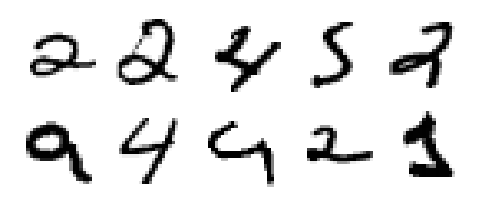

In [4]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.axis('off')

def plot_digits(instances, images_per_row=5):
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(28,28) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((28, 28 * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.figure(figsize=(images_per_row * 1.2, n_rows * 1.2))
    plt.imshow(image, cmap=plt.cm.binary)
    plt.axis("off")

# Define the uncertainty sampling function
def uncertainty_sampling(model, X_pool, n_instances=10):
    # Predict class probabilities
    probas = model.predict_proba(X_pool)
    # Select the instances where the prediction confidence is the lowest
    uncertainty_index = np.argsort(np.max(probas, axis=1))[:n_instances]
    return uncertainty_index

# Initialize the model
model = RandomForestClassifier()

# Initial random sample
np.random.seed(42) # For reproducibility
initial_idx = np.random.choice(range(len(x_train)), 50, replace=False)
X_initial, y_initial = x_train[initial_idx], y_train[initial_idx]

# Remaining pool
X_pool = np.delete(x_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

model.fit(X_initial, y_initial)

# Perform a round of uncertainty sampling
query_idx = uncertainty_sampling(model, X_pool, 10)
X_query, y_query = X_pool[query_idx], y_pool[query_idx]

# Plot sampled digits
plot_digits(X_query)

# Update the training set
X_initial = np.concatenate([X_initial, X_query])
y_initial = np.concatenate([y_initial, y_query])

# Remove selected samples from the pool
X_pool = np.delete(X_pool, query_idx, axis=0)
y_pool = np.delete(y_pool, query_idx, axis=0)

# Re-train and evaluate the model
model.fit(X_initial, y_initial)
predictions = model.predict(x_test)
print(f"Updated model accuracy: {accuracy_score(y_test, predictions):.4f}")


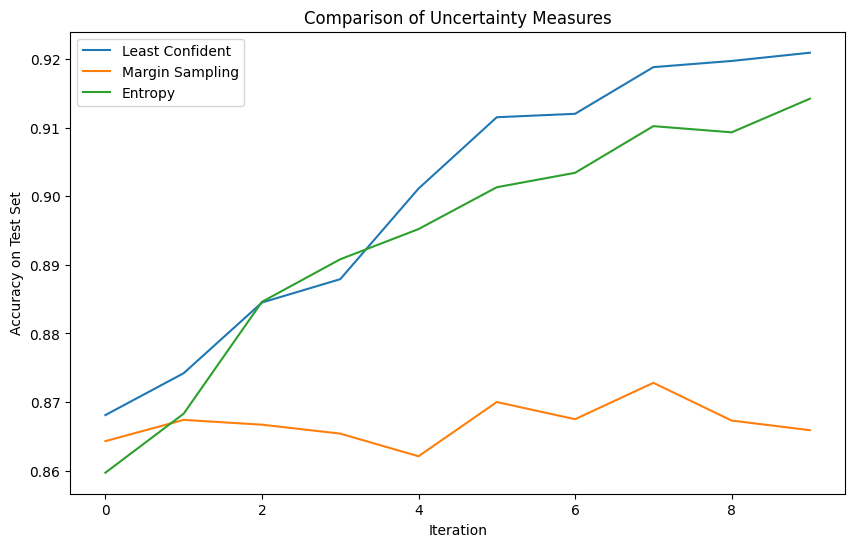

In [9]:
from keras.datasets import mnist
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocessing
x_train = x_train.reshape((x_train.shape[0], -1)).astype('float32') / 255
x_test = x_test.reshape((x_test.shape[0], -1)).astype('float32') / 255
y_train = np.array(y_train)
y_test = np.array(y_test)

# Initialize a small labeled dataset and a larger unlabeled pool
np.random.seed(42)
initial_idx = np.random.choice(range(len(x_train)), size=500, replace=False)
X_labeled = x_train[initial_idx]
y_labeled = y_train[initial_idx]
X_unlabeled = np.delete(x_train, initial_idx, axis=0)
y_unlabeled = np.delete(y_train, initial_idx, axis=0)

def uncertainty_least_confident(probas):
    # Least confident: 1 - max(class probabilities)
    return 1 - np.max(probas, axis=1)

def uncertainty_margin_sampling(probas):
    # Margin sampling: difference between the top two class probabilities
    part = np.partition(-probas, 1, axis=1)
    return -part[:, 0] + part[:, 1]

def uncertainty_entropy(probas):
    # Entropy
    return -np.sum(probas * np.log(probas + 1e-5), axis=1)  # add a small value to prevent log(0)

def plot_uncertainty_iterations(X_labeled, y_labeled, X_unlabeled, measure_func, title, n_iterations=10, n_instances=100,y_unlabeled=y_unlabeled,x_test=x_test,y_test=y_test):
    model = RandomForestClassifier()
    accuracies = []
    
    for i in range(n_iterations):
        model.fit(X_labeled, y_labeled)
        probas = model.predict_proba(X_unlabeled)
        uncertainties = measure_func(probas)
        query_idx = np.argsort(uncertainties)[-n_instances:]
        
        # Update the labeled and unlabeled datasets
        X_labeled = np.vstack([X_labeled, X_unlabeled[query_idx]])
        y_labeled = np.concatenate([y_labeled, y_unlabeled[query_idx]])
        X_unlabeled = np.delete(X_unlabeled, query_idx, axis=0)
        y_unlabeled = np.delete(y_unlabeled, query_idx, axis=0)
        
        # Evaluate and store the accuracy
        acc = accuracy_score(y_test, model.predict(x_test))
        accuracies.append(acc)
    
    plt.plot(accuracies, label=title)

plt.figure(figsize=(10, 6))

# Plot the accuracy improvement for each uncertainty measure
plot_uncertainty_iterations(X_labeled, y_labeled, X_unlabeled, uncertainty_least_confident, 'Least Confident')
plot_uncertainty_iterations(X_labeled, y_labeled, X_unlabeled, uncertainty_margin_sampling, 'Margin Sampling')
plot_uncertainty_iterations(X_labeled, y_labeled, X_unlabeled, uncertainty_entropy, 'Entropy')

plt.xlabel('Iteration')
plt.ylabel('Accuracy on Test Set')
plt.title('Comparison of Uncertainty Measures')
plt.legend()
plt.show()

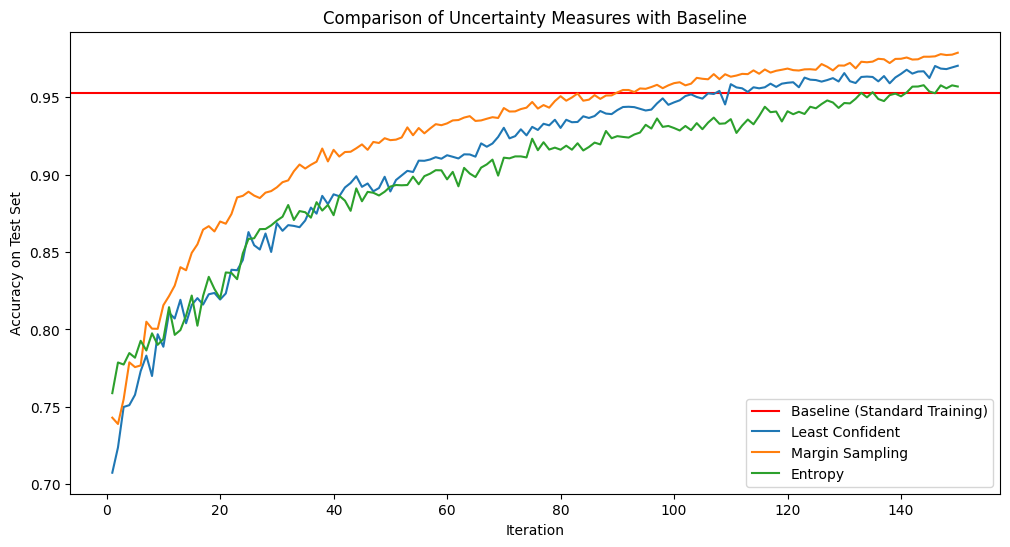

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def run_active_learning(X, y, model, uncertainty_measure, iterations=10, subset_percent=1.0, n_queries=10):
    # Take a subset of the dataset if specified
    if subset_percent < 1.0:
        X, _, y, _ = train_test_split(X, y, train_size=subset_percent, stratify=y)

    # Split initial training data
    X_train, X_pool, y_train, y_pool = train_test_split(X, y, test_size=0.99, stratify=y)
    
    accuracies = []

    for i in range(iterations):
        # Fit the model
        model.fit(X_train, y_train)
        
        # Evaluate the model on the full dataset and store the accuracy
        acc = accuracy_score(y, model.predict(X))
        accuracies.append(acc)

        # Predict the pool to get uncertainties
        probas = model.predict_proba(X_pool)
        
        # Select samples based on the uncertainty measure
        query_idx = uncertainty_measure(probas, n_queries)
        
        # "Label" these samples and add them to the training set
        X_train = np.vstack([X_train, X_pool[query_idx]])
        y_train = np.concatenate([y_train, y_pool[query_idx]])
        
        # Remove the labeled samples from the pool
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

    return accuracies


def run_baseline_model(X, y, model, subset_percent=1.0, test_size=0.2):
    # Take a subset of the dataset if specified
    if subset_percent < 1.0:
        X, _, y, _ = train_test_split(X, y, train_size=subset_percent, stratify=y)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate the model
    acc = accuracy_score(y_test, model.predict(X_test))
    
    return acc

def uncertainty_least_confident(probas, n_queries):
    # Select the n_queries instances with the lowest maximum predicted probability (i.e., least confident)
    return np.argsort(probas.max(axis=1))[:n_queries]

def uncertainty_margin_sampling(probas, n_queries):
    # Select the n_queries instances where the difference between the first and second most probable classes is smallest
    part_sorted = np.partition(-probas, 1, axis=1)
    margins = -part_sorted[:, 0] + part_sorted[:, 1]
    return np.argsort(margins)[:n_queries]

def uncertainty_entropy(probas, n_queries):
    # Select the n_queries instances with the highest entropy
    return np.argsort(-entropy(probas.T, base=2, axis=0))[:n_queries]

def random_sampling(probas, n_queries):
    # Select n_queries random instances for labeling
    return np.random.choice(probas.shape[0], size=n_queries, replace=False)


# Assuming we have defined uncertainty functions and have the MNIST data loaded into X, y

# Create the model
rf_model = RandomForestClassifier()

# Define the percentage of the dataset to use for active learning and baseline model
subset_percent = 0.2  # 10% of the dataset

# Baseline model: Standard training approach
baseline_accuracy = run_baseline_model(X, y, rf_model, subset_percent)

# Perform active learning with uncertainty sampling methods
# For active learning, we will run for a number of iterations
iterations = 150
least_confident_accuracies = run_active_learning(X, y, rf_model, uncertainty_least_confident, iterations, subset_percent)
margin_sampling_accuracies = run_active_learning(X, y, rf_model, uncertainty_margin_sampling, iterations, subset_percent)
entropy_accuracies = run_active_learning(X, y, rf_model, uncertainty_entropy, iterations, subset_percent)

# Plot the results
plt.figure(figsize=(12, 6))
iteration_indices = list(range(1, iterations + 1))
plt.axhline(y=baseline_accuracy, color='r', linestyle='-', label='Baseline (Standard Training)')
plt.plot(iteration_indices, least_confident_accuracies, label='Least Confident')
plt.plot(iteration_indices, margin_sampling_accuracies, label='Margin Sampling')
plt.plot(iteration_indices, entropy_accuracies, label='Entropy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy on Test Set')
plt.title('Comparison of Uncertainty Measures with Baseline')
plt.legend()
plt.show()


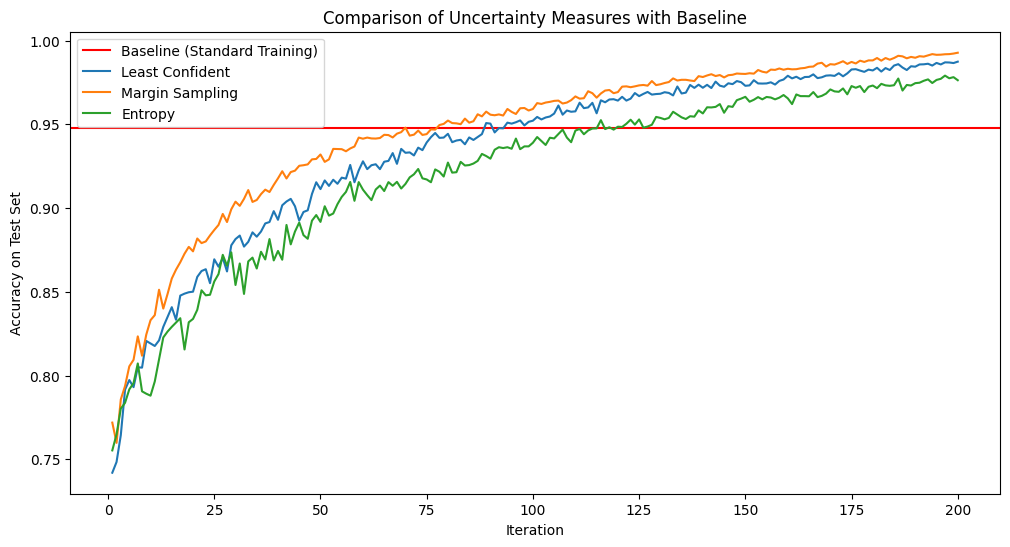

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def run_active_learning(X, y, model, uncertainty_measure, iterations=10, subset_percent=1.0, n_queries=10):
    # Take a subset of the dataset if specified
    if subset_percent < 1.0:
        X, _, y, _ = train_test_split(X, y, train_size=subset_percent, stratify=y)

    # Split initial training data
    X_train, X_pool, y_train, y_pool = train_test_split(X, y, test_size=0.99, stratify=y)
    
    accuracies = []

    for i in range(iterations):
        # Fit the model
        model.fit(X_train, y_train)
        
        # Evaluate the model on the full dataset and store the accuracy
        acc = accuracy_score(y, model.predict(X))
        accuracies.append(acc)

        # Predict the pool to get uncertainties
        probas = model.predict_proba(X_pool)
        
        # Select samples based on the uncertainty measure
        query_idx = uncertainty_measure(probas, n_queries)
        
        # "Label" these samples and add them to the training set
        X_train = np.vstack([X_train, X_pool[query_idx]])
        y_train = np.concatenate([y_train, y_pool[query_idx]])
        
        # Remove the labeled samples from the pool
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

    return accuracies


def run_baseline_model(X, y, model, subset_percent=1.0, test_size=0.2):
    # Take a subset of the dataset if specified
    if subset_percent < 1.0:
        X, _, y, _ = train_test_split(X, y, train_size=subset_percent, stratify=y)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate the model
    acc = accuracy_score(y_test, model.predict(X_test))
    
    return acc

def uncertainty_least_confident(probas, n_queries):
    # Select the n_queries instances with the lowest maximum predicted probability (i.e., least confident)
    return np.argsort(probas.max(axis=1))[:n_queries]

def uncertainty_margin_sampling(probas, n_queries):
    # Select the n_queries instances where the difference between the first and second most probable classes is smallest
    part_sorted = np.partition(-probas, 1, axis=1)
    margins = -part_sorted[:, 0] + part_sorted[:, 1]
    return np.argsort(margins)[:n_queries]

def uncertainty_entropy(probas, n_queries):
    # Select the n_queries instances with the highest entropy
    return np.argsort(-entropy(probas.T, base=2, axis=0))[:n_queries]

def random_sampling(probas, n_queries):
    # Select n_queries random instances for labeling
    return np.random.choice(probas.shape[0], size=n_queries, replace=False)


# Assuming we have defined uncertainty functions and have the MNIST data loaded into X, y

# Create the model
rf_model = RandomForestClassifier()

# Define the percentage of the dataset to use for active learning and baseline model
subset_percent = 0.2  # 10% of the dataset

# Baseline model: Standard training approach
baseline_accuracy = run_baseline_model(X, y, rf_model, subset_percent)

# Perform active learning with uncertainty sampling methods
# For active learning, we will run for a number of iterations
iterations = 200
least_confident_accuracies = run_active_learning(X, y, rf_model, uncertainty_least_confident, iterations, subset_percent)
margin_sampling_accuracies = run_active_learning(X, y, rf_model, uncertainty_margin_sampling, iterations, subset_percent)
entropy_accuracies = run_active_learning(X, y, rf_model, uncertainty_entropy, iterations, subset_percent)

# Plot the results
plt.figure(figsize=(12, 6))
iteration_indices = list(range(1, iterations + 1))
plt.axhline(y=baseline_accuracy, color='r', linestyle='-', label='Baseline (Standard Training)')
plt.plot(iteration_indices, least_confident_accuracies, label='Least Confident')
plt.plot(iteration_indices, margin_sampling_accuracies, label='Margin Sampling')
plt.plot(iteration_indices, entropy_accuracies, label='Entropy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy on Test Set')
plt.title('Comparison of Uncertainty Measures with Baseline')
plt.legend()
plt.show()


<h1> Graph above </h1> <br>


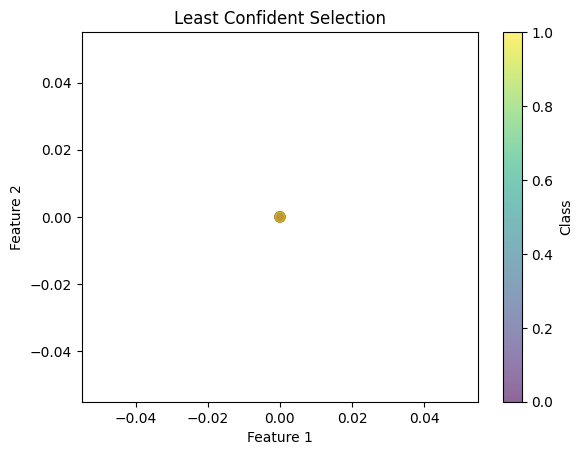

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import entropy

# Assume these functions are defined:
# predict_proba: Given a model and data, returns predicted probabilities for each class.
# select_data_points: A generic function to select data points based on a given uncertainty measure.

def uncertainty_least_confident(probas):
    """Select instances with the lowest maximum predicted probability."""
    return np.argsort(-probas.max(axis=1))

def uncertainty_margin_sampling(probas):
    """Select instances based on the smallest margin between the two most probable classes."""
    # Sort the probabilities
    part_sorted = np.partition(-probas, 1, axis=1)
    # Calculate margins
    margins = -part_sorted[:, 0] + part_sorted[:, 1]
    return np.argsort(margins)

def uncertainty_entropy(probas):
    """Select instances with the highest entropy."""
    return np.argsort(-entropy(probas.T))

def visualize_selection(X, y, title):
    """A simple function to visualize the data points."""
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50, alpha=0.6)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(label='Class')
    plt.show()

def plot_uncertainty_iterations(X_labeled, y_labeled, X_unlabeled, y_unlabeled, uncertainty_func, title):
    """Plot data points selected by a specific uncertainty measure."""
    model = RandomForestClassifier()
    model.fit(X_labeled, y_labeled)
    probas = model.predict_proba(X_unlabeled)
    
    query_idx = uncertainty_func(probas)[:10]
    visualize_selection(X_unlabeled[query_idx], y_unlabeled[query_idx], title)

# Example of running the function for 1 iteration
# Assuming X_labeled, y_labeled, X_unlabeled, y_unlabeled are defined

# Simulate one iteration for "Least Confident"
plot_uncertainty_iterations(X_labeled, y_labeled, X_unlabeled, y_unlabeled, uncertainty_least_confident, 'Least Confident Selection')
